### Train MINIST classifier using CNN
https://lightning.ai/courses/deep-learning-fundamentals/unit-7-overview-getting-started-with-computer-vision/unit-7.4-training-convolutional-neural-networks/

In [10]:
import torch
import torchvision
import lightning
from lightning.pytorch.loggers import CSVLogger
from torchvision import datasets, transforms
from torch.utils.data import dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from common_def import PyTorchMLP, LightningModel, plot_metrics_from_csv_log

#### Examine Dataset

In [11]:
class MnistDataModule(lightning.LightningDataModule):
    def __init__(self, data_dir='./dataset/mnist', batch_size=256):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

    def prepare_data(self):
        self.train_dataset = datasets.MNIST(root=self.data_dir, train=True, transform=transforms.ToTensor(), download=True)
        self.test_dataset = datasets.MNIST(root=self.data_dir, train=False, transform=transforms.ToTensor(), download=True)

    def setup(self, stage=None):
        self.train_dataset, self.val_dataset = dataset.random_split(dataset=self.train_dataset, lengths=[55000, 5000])

    def train_dataloader(self):
        return DataLoader(dataset=self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=10)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=10)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_dataset, batch_size=self.batch_size, shuffle=False)

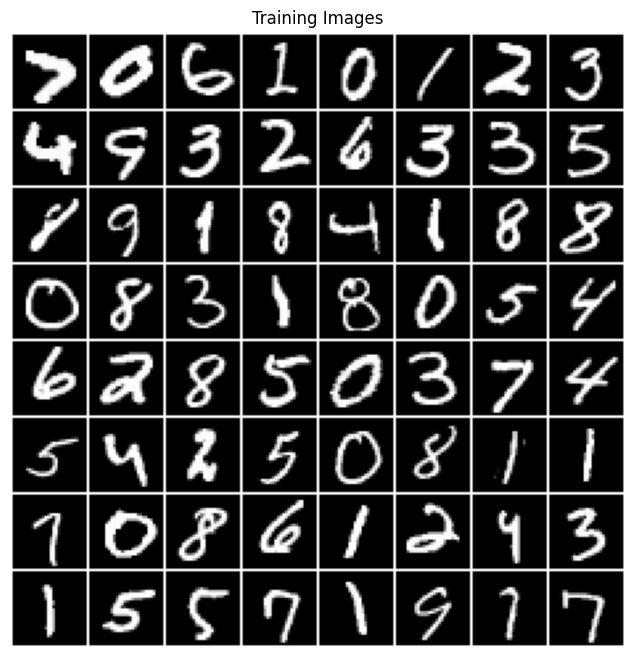

In [12]:
mnist_dm = MnistDataModule()
mnist_dm.prepare_data()
mnist_dm.setup(stage='Train')

for images, labels in mnist_dm.train_dataloader():
    break 

plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(
    np.transpose(torchvision.utils.make_grid(
        images[:64],
        padding=1,
        pad_value=1.0,
        normalize=True
    ),
    (1, 2, 0)))

plt.show()

#### Training with MLP Baseline

In [13]:
lightning.seed_everything(1)

mnist_datamodule = MnistDataModule(batch_size=256)

mlp_model = PyTorchMLP(num_features=784, num_classes=10)
lightning_model = LightningModel(torch_model=mlp_model, learning_rate=0.1, num_classes=10)
trainer = lightning.Trainer(max_epochs=10, logger=CSVLogger(save_dir='lightning_logs', name='MLP_Baseline'), deterministic=True)

trainer.fit(model=lightning_model, datamodule=mnist_datamodule)

Seed set to 1
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type               | Params
---------------------------------------------------
0 | torch_model | PyTorchMLP         | 40.9 K
1 | train_acc   | MulticlassAccuracy | 0     
2 | val_acc     | MulticlassAccuracy | 0     
---------------------------------------------------
40.9 K    Trainable params
0         Non-trainable params
40.9 K    Total params
0.164     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 215/215 [00:10<00:00, 20.89it/s, v_num=7, val_acc=0.968, train_acc=0.989]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 215/215 [00:10<00:00, 20.51it/s, v_num=7, val_acc=0.968, train_acc=0.989]


In [14]:
trainer.test(model=lightning_model, datamodule=mnist_datamodule)

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 27.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9746000170707703
        test_loss           0.08562911301851273
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.08562911301851273, 'test_acc': 0.9746000170707703}]

Visualize metrics

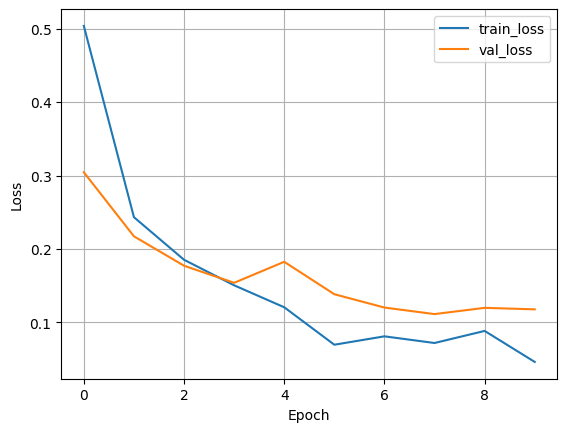

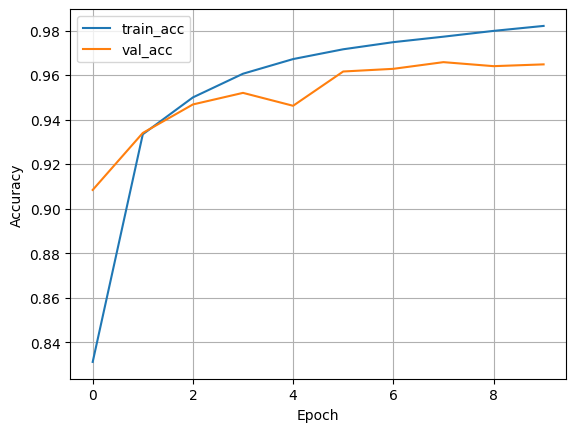

In [15]:
plot_metrics_from_csv_log(path='lightning_logs/MLP_Baseline/version_2/metrics.csv')

#### Training with CNN

In [16]:
class PyTorchCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.cnn_layers = torch.nn.Sequential(
            torch.nn.Conv2d(1, 3, kernel_size=5),
            torch.nn.BatchNorm2d(3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),

            torch.nn.Conv2d(3, 16, kernel_size=3),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),

            torch.nn.Conv2d(16, 32, kernel_size=3),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
        )

        self.fc_layers = torch.nn.Sequential(
            # hidden layer
            torch.nn.Linear(32, 20),
            torch.nn.BatchNorm1d(20),
            torch.nn.ReLU(),

            # output layer
            torch.nn.Linear(20, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = torch.flatten(x, start_dim=1)
        return self.fc_layers(x)

In [17]:
lightning.seed_everything(1)

mnist_datamodule = MnistDataModule(batch_size=256)

cnn_model = PyTorchCNN(num_classes=10)
lightning_model = LightningModel(torch_model=cnn_model, num_classes=10, learning_rate=0.1)
trainer = lightning.Trainer(max_epochs=10, logger=CSVLogger(save_dir='lightning_logs', name='CNN'), deterministic=True)

trainer.fit(model=lightning_model, datamodule=mnist_datamodule)

Seed set to 1


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'torch_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['torch_model'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name        | Type               | Params
---------------------------------------------------
0 | torch_model | PyTorchCNN         | 6.2 K 
1 | train_acc   | MulticlassAccuracy | 0     
2 | val_acc     | MulticlassAccuracy | 0     
---------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 9: 100%|██████████| 215/215 [00:12<00:00, 17.89it/s, v_num=4, val_acc=0.983, train_acc=0.989]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 215/215 [00:12<00:00, 17.77it/s, v_num=4, val_acc=0.983, train_acc=0.989]


In [18]:
trainer.test(model=lightning_model, datamodule=mnist_datamodule)

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 40/40 [00:00<00:00, 41.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9825000166893005
        test_loss          0.057217057794332504
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.057217057794332504, 'test_acc': 0.9825000166893005}]

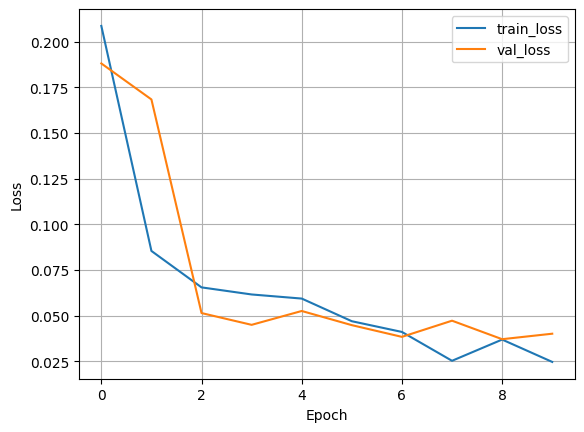

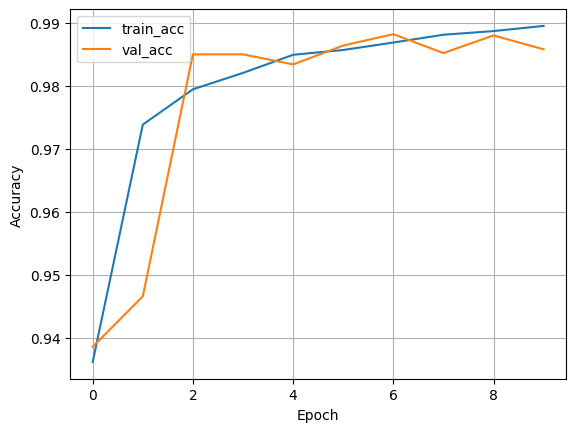

In [19]:
plot_metrics_from_csv_log(path='lightning_logs/CNN/version_0/metrics.csv')